TIF images → `Extract-Channels` → `Visualize-Inputs` → `Predict-Segments` → `Visualize-Segmentation` → predicted segmentations

From source image, extract the nuclear & membrane channels. Save each to npz.

Not sure how we'll configure channel extraction. Maybe should do that individually.

In [1]:
import numpy as np
import os
import smart_open

import tifffile

In [2]:
input_path = 'gs://davids-genomics-data-public/cellular-segmentation/hubmap/hbm458.nffx.729_451Mpx/VAN0048-LK-1-32-preAF-registered.ome.tiff'
output_path = 'gs://davids-genomics-data-public/cellular-segmentation/hubmap/hbm458.nffx.729_451Mpx/input_channels.npz'

In [3]:
with smart_open.open(input_path, 'rb') as input_file:
    # Input file specified here: https://portal.hubmapconsortium.org/browse/dataset/f998d229419480586317be5866079c2f
    
    tif = tifffile.TiffFile(input_file)
    
    # Channels:
    # DAPI (excitation: 335-383 nm/emission: 420-470 nm)
    # eGFP (excitation: 450-490 nm/emission: 500-550 nm)
    # dsRed (excitation: 538-562 nm/emission: 570-640 nm)
    
    # Channel 0 = DAPI (excitation: 335-383 nm/emission: 420-470 nm)
    channel_0 = tif.pages[0].asarray()

    # Channel 1 = eGFP (excitation: 450-490 nm/emission: 500-550 nm)
    channel_1 = tif.pages[1].asarray()

    # Channel 2 = dsRed (excitation: 538-562 nm/emission: 570-640 nm)
    # channel_2 = tif.pages[2].asarray()

    # Select the membrane channel
    input_membrane = channel_1

    # Select the nuclear channel
    input_nuclear = channel_0
    
    tif.close()

In [4]:
# Stack the nuclear & membrane channels together.
input_channels = np.stack([input_nuclear, input_membrane], axis=-1)

In [5]:
# Write the resulting 3d array (rows, cols, 2 intensity channels) to output
with smart_open.open(output_path, 'wb') as output_file:
  np.savez_compressed(output_file, input_channels=input_channels)

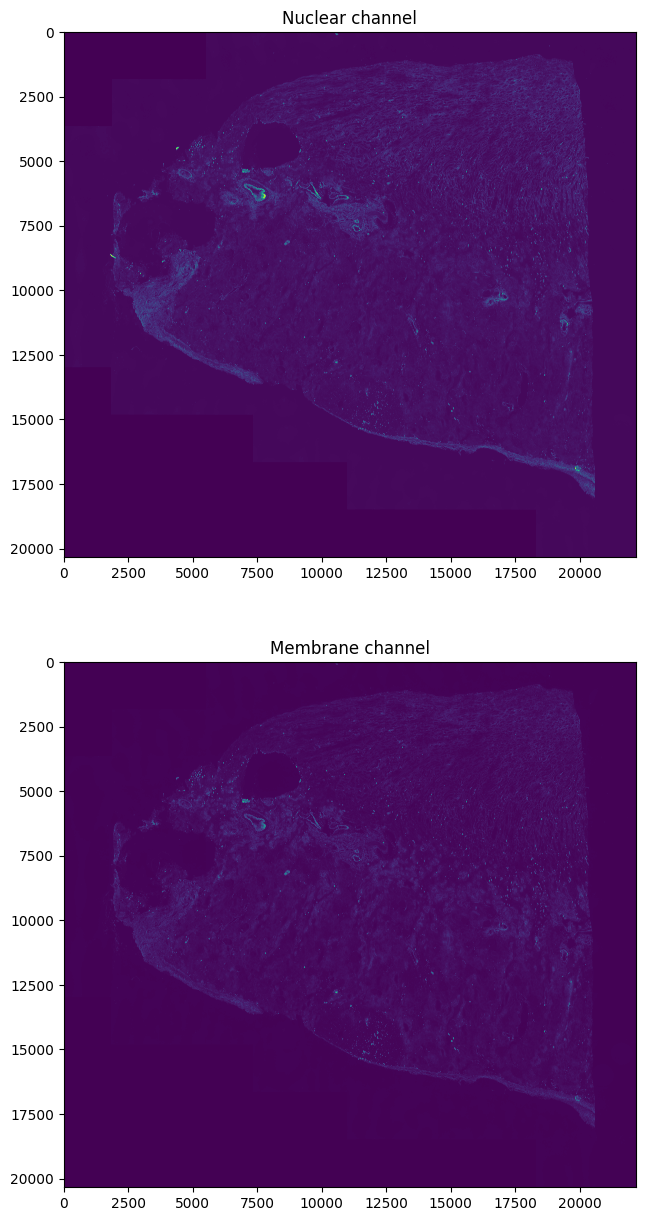

In [6]:
# Visualize nuclear/membrane channels
from matplotlib import pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(15, 15))
ax[0].imshow(input_channels[..., 0])
ax[1].imshow(input_channels[..., 1])
ax[0].set_title('Nuclear channel')
ax[1].set_title('Membrane channel')
plt.show()

In [7]:
print(input_channels[..., 0].shape)
print(input_channels[..., 0].min())
print(input_channels[..., 0].max())

(20338, 22162)
0
65535


In [8]:
cols = input_channels[..., 0].shape[1] * 0.20
rows = input_channels[..., 0].shape[0] * 0.20

In [9]:
from PIL import Image

image_data = input_channels[..., 0]
normalized_image = image_data * (255.0/image_data.max())
im = Image.fromarray(normalized_image.astype(np.uint8), mode='L')
im = im.resize((int(cols), int(rows)))
im.save(f'input_nuclear.png')